<a href="https://colab.research.google.com/github/drewwint/neuromatch-2021/blob/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Sequential Probability Ratio Test
**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

__Content creators:__ Yicheng Fei and Xaq Pitkow

__Content reviewers:__ John Butler, Matt Krause, Spiros Chavlis, Michael Waskom, Jesse Livezey, and Byron Galbraith

---
# Tutorial Objectives

In W3D1, we learned how to combine the sensory evidence and our prior experience with Bayes' Theorem, producing a posterior probability distribution that would let us choose between the most probable of *two* options (fish being on the left or fish being on the right).

Here, we add a *third* option: choosing to collect more evidence before making a decision.

---

In this notebook we will perform a *Sequential Probability Ratio Test* (SPRT) between two hypotheses $s=+1$ and $s=-1$ by running simulations of a *Drift Diffusion Model (DDM)*. As data comes in, we accumulate evidence linearly until a stopping criterion is met before deciding which hypothesis to accept.

In this tutorial, you will
* Simulate the Drift-Diffusion Model.
* Gain intuition about the tradeoff between decision speed and accuracy.

In [4]:
# @title Video 1: Overview of Tutorials on Hidden Dynamics
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ofNRpSpRxl4", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Setup

In [1]:
# Imports
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [3]:
#@title Helper functions

def simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample,
                                     verbose=True):
  """Simulate and plot a SPRT for a fixed amount of time given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    stop_time (int): Number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
    """

  evidence_history_list = []
  if verbose:
    print("#Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_fixedtime(sigma, stop_time)
    if verbose:
      print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                  "stopping rule")

  plt.show(fig)


def plot_accuracy_vs_stoptime(stop_time_list, accuracy_list):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    stop_time_list (int): List of number of steps to run before stopping.
    accuracy_list (int): List of accuracies for each stop time
  """

  fig, ax = plt.subplots()
  ax.plot(stop_time_list, accuracy_list)
  ax.set_xlabel('Stop Time')
  ax.set_ylabel('Average Accuracy')

  plt.show(fig)


def simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha,
                                          verbose=True):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    num_sample (int): The number of samples to plot.
    alpha (float): Threshold for making a decision.
  """
  # calculate evidence threshold from error rate
  threshold = threshold_from_errorrate(alpha)

  # run simulation
  evidence_history_list = []
  if verbose:
    print("#Trial\tTime\tCumulated Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_threshold(sigma, threshold)
    if verbose:
      print("{}\t{}\t{:f}\t{}".format(i, len(Mvec), evidence_history[-1],
                                      decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(-np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(np.zeros(maxlen_evidence + 1), '--', c='red', alpha=0.5)

  for evidences in evidence_history_list:
      ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0], evidences]))

  ax.set_xlabel("Time")
  ax.set_ylabel("Cumulated log likelihood ratio")
  ax.set_title("Log likelihood ratio trajectories under the threshold rule")

  plt.show(fig)


def simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Simulate and plot a SPRT for a set of thresholds given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    alpha_list (float): List of thresholds for making a decision.
    num_sample (int): The number of samples to plot.
  """
  accuracies, decision_speeds = simulate_accuracy_vs_threshold(sigma,
                                                               threshold_list,
                                                               num_sample)

  # Plotting
  fig, ax = plt.subplots()
  ax.plot(decision_speeds, accuracies, linestyle="--", marker="o")
  ax.plot([np.amin(decision_speeds), np.amax(decision_speeds)],
          [0.5, 0.5], c='red')
  ax.set_xlabel("Average Decision speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(0.45, 1.05)

  plt.show(fig)


def threshold_from_errorrate(alpha):
  """Calculate log likelihood ratio threshold from desired error rate `alpha`

  Args:
    alpha (float): in (0,1), the desired error rate

  Return:
    threshold: corresponding evidence threshold
  """
  threshold = np.log((1. - alpha) / alpha)
  return threshold

---

# Section 1: Introduction to the SPRT


## Section 1.1: The random dot task

A classic experimental task in neuroscience is the random dot kinematogram ([Newsome, Britten, Movshon 1989](https://www.nature.com/articles/341052a0.pdf)), in which a pattern of moving dots are moving in random directions but with some weak coherence that favors a net rightward or leftward motion. The observer must guess the direction. Neurons in the brain are informative about this task, and have responses that correlate with the choice.

Below is a video by Pamela Reinagle of a rat guessing the direction of motion in such a task.

In [5]:
# @title Video 2: Rat performing the Random Dot Motion Task
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="oDxcyTn-0os", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In this tutorial, we will consider a model for this random dot motion task. In each time bin $t$, we are shown dots moving at net measured velocity $m_t$, either in a negative ($m<0$) or positive ($m>0$) direction. Although the dots' velocities varies over time, the $m_t$ are generated by a fixed probability distribution $p(m|s)$ that depends on a fixed latent variable $s=\pm 1$:
$$
\\
\begin{eqnarray}
p(m|s=+1) &=& \mathcal{N}\left(\mu_+,\sigma^2\right) \\
&&\textrm{or} \\
p(m|s=-1) &=& \mathcal{N}\left(\mu_-,\sigma^2\right) \\
\end{eqnarray} 
\\
$$
Here we assume the measurement probabilities have the same variances regardless of $s$, and different means. We, like the rat, want to synthesize our evidence to determine whether $s=+1$ or $-1$. 


#### note 
- I think $s$ is the utility 

## Section 1.2: Sequential Probability Ratio Test(SPRT)

In [6]:
# @title Video 3: Decision making: Sequential Probability Ratio Test
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1yf4y1R7P8", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="DGoPoLkDiUw", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)



<!-- <img alt="PGM" width="400" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_DecisionMaking/static/W2D3_Tutorial1_PGM.png?raw=true"> -->


<img src="https://drive.google.com/uc?export=view&id=1vE2XQ5qMQ_pJgzgZRCnNVQEpP-nupt87" alt="HMM drawing" width="400">

Suppose we obtain a sequence of independent measurements $m_{1:T}$ from a distribution $p(m_{1:T}|s)$. Remember that $s$ is our hidden state and for now, is either -1 or 1. Our measurements come from either $p(m_t|s=-1)$ or $p(m_t|s=1)$. We wish to test which value of $s$ is more likely given our sequence of measurements.

A crucial assumption in Hidden Markov Models is that all measurements are drawn independently given the latent state. In the fishing example, you might have a high or low probability of catching fish depending on where the school of fish is --- but if you already *knew* the location $s$ of the school (which is what we mean by a conditional probability $p(m|s)$), then your chances of catching fish at one time is unaffected by whether you caught fish there previously.

Mathematically, we write this independence as $p(m_1, m_2|s)=p(m_1|s)p(m_2|s)$, using the product rule of probabilities.  When we consider a whole time series of measurements $m_{1:T}$, we can compute the product $p(m_{1:T}|s)=\prod_{t=1}^T p(m_t|s)$.

We can then compare the total evidence up to time $T$ for our two hypotheses (of whether our state is -1 or 1) by taking a ratio
of the likelihoods.

$$L_t=\frac{\prod_{t=1}^T p(m_t|s=+1)}{\prod_{t=1}^T p(m_t|s=-1)}$$

The above tells us the likelihood of the measurements if $s = 1$ divided by the likelihood of the measurements if $s = -1$.

It is convenient to take the _log_ of this likelihood ratio, converting the products to sums:

$$S_t = \log L_t = \sum_{t=1}^T \log \frac{p(m_t|s=+1)}{p(m_t|s=-1)} \tag{1}$$
We can name each term in the sum as
$$\Delta_t= \log \frac{p(m_t|s=+1)}{p(m_t|s=-1)}$$
Due to the independence of measurements, this can be calculated recursively _online_ as new data points arrive:

$$ S_t =  S_{t-1} + \Delta_t \tag{2}$$
where we update our log-likelihood ratio $S_t$ by $\Delta_t$ every time we see a new measurement $m_t$.

We will use $S_t$ to make our decisions! If $S_t$ is positive, the likelihood of $s = 1$ is higher. If it is negative, the likelihood of $s = -1$ is higher. We need to figure out when we make our decision though, as $S_t$ can change with each new measurement.


A rule for making a decision can be implemented in two ways:

1. Fixed time (Section 2): Stop collecting data after a predetermined number of measurements $t$, and accept the hypothesis that $s=+1$ if $S_t>0$, otherwise accept $s=-1$ if $S_t<0$ (and choose randomly if $S_t=0$). The significance level or desired error rate $\alpha$ can then be determined as $\alpha = (1+\exp(|S_t|))^{-1}$.

2. Confidence threshold (Bonus Section 1): Choose an acceptable error rate $\alpha$. Then accept the hypothesis $s=1$ when $S_t \ge b=\log \frac{1-\alpha}{\alpha}$, analogously accept $s=-1$ when $S_t\le -b$, and keep collecting data until one of those confidence thresholds is reached. Historical note: this is the rule that Alan Turing used to break the Enigma code and win World War II!

## Section 1.3: SPRT as a Drift Diffusion Model (DDM)

In [7]:
# @title Video 4: SPRT and the Random Dot Motion Task
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Pt4y1X7F3", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="7WBB4M_Vf58", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

The evidence favoring the two latent states is random, but according to our model it will weakly favor one hypothesis over another. The accumulation of evidence will thus "drift" toward one outcome, while "diffusing" in random directions, hence the term "drift-diffusion model" (DDM). The process is most likely (but not guaranteed) to reach the correct outcome eventually. We can do a little math below to show that the update $\Delta_t$ to the log-likelihood ratio is a gaussian random number. You can derive this yourself, filling in the steps below, or skip to the end result.

**Bonus exercise: derive Drift Diffusion Model from SPRT**

Assume measurements are Gaussian-distributed with different means depending on the discrete latent variable $s$:
$$p(m|s=\pm 1) = \mathcal{N}\left(\mu_\pm,\sigma^2\right)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(m-\mu_\pm)^2}{2\sigma^2}\right]}$$

In the log likelihood ratio for a single data point $m_i$, the normalizations cancel to give
$$\Delta_t=\log \frac{p(m_t|s=+1)}{p(m_t|s=-1)} = \frac{1}{2\sigma^2}\left[-\left(m_t-\mu_+\right)^2 + (m_t-\mu_-)^2\right] \tag{5}$$

It's convenient to rewrite $m=\mu_\pm + \sigma \epsilon$, where $\epsilon\sim \mathcal{N}(0,1)$ is a standard Gaussian variable with zero mean and unit variance. (Why does this give the correct probability for $m$?). The preceding formula can then be rewritten as 
$$\Delta_t = \frac{1}{2\sigma^2}\left( -((\mu_\pm+\sigma\epsilon)-\mu_+)^2 + ((\mu_\pm+\sigma\epsilon)-\mu_-)^2\right) \tag{5}$$

- $Note:$ above in the video the equation outcome was a log lambda but here it is a delta_t. Thus the right side is the diffusion term and the left side is the drift term

Let's assume that $s=+1$ so $\mu_\pm=\mu_+$ (if $s=-1$ then the result is the same with a reversed sign). In that case, the means in the first term $m_t-\mu_+$ cancel, leaving
$$\Delta_t = \frac{(\mu_+-\mu_-)^2}{2\sigma^2}+\frac{\mu_+-\mu_-}{\sigma}\epsilon \tag{5}$$
where the first term is the constant *drift*, and the second term is the random *diffusion*. Adding these $\Delta_t$ over time gives a biased random walk known as the Drift Diffusion Model, $S_t=\sum_t \Delta_t$. The log-likelihood ratio is then normally distributed with a time-dependent mean and variance, 
$$S_t\sim\mathcal{N}\left(\tfrac{1}{2}\frac{\delta\mu^2}{\sigma^2}t,\ \frac{\delta\mu^2}{\sigma^2}t\right)$$
where $\delta\mu=\mu_+-\mu_-$. The mean and the variance both increase linearly with time, so the standard deviation grows more slowly, as only $\sqrt{t}$. This means that the distributions becomes more and more distinct as evidence is acquired over time. You will simulate this process below.

**Neural application**

Neural responses in lateral intraparietal cortex (LIP) to the random-dots kinematogram has been well-described by this drift-diffusion process (Huk and Shadlen 2005), suggesting that these neurons gradually integrate evidence. Interestingly there is also a more recent competing hypothesis that neural activity jumps from low to high at random latent times, such that on average it looks like a gradual ramping (Latimer et al 2015). Scientific evidence about these processes are judged by how well the corresponding Hidden Markov Models fit the data!



---
# Section 2: DDM with fixed-time stopping rule


## Section 2.1: Simulation of DDM with fixed-time stopping rule

In [8]:
# @title Video 5: Simulate the DDM with a fixed-time stopping rule
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Ak4y1m7kb", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="9WNAZnEa64Y", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Coding Exercise 1: Simulating an SPRT model

Assume we are performing a random dot motion task and at each time we see a moving dot with a sensory measurement $m_t$ of velocity. All data points are sampled from the same distribution $p$, which is either $p_+=\mathcal{N}\left(\mu,\sigma^2\right)$ or $p_-=\mathcal{N}\left(-\mu,\sigma^2\right)$, depending on which direction the dots are moving in. Let's now generate some simulated data under this setting and perform SPRT using the fixed time stopping rule. 

In this exercise, without loss of generality, we assume the true data-generating model is $p_+$.

We will implement a function `simulate_SPRT_fixedtime`, which will generate measurements based on $\mu$, $\sigma$, and the true state. It will then accumulate evidence and output a decision on the state. We will use the helper function `log_likelihood_ratio`, implemented in the next cell, which computes the log of the likelihood of the state being 1 divided by the likelihood of the state being -1. 

We will then run and visualize 10 simulations of evidence accumulation and decision.




In [9]:
# @markdown Execute this cell to enable the helper function log_likelihood_ratio

def log_likelihood_ratio(Mvec, p0, p1):
  """Given a sequence(vector) of observed data, calculate the log of
  likelihood ratio of p1 and p0

  Args:
    Mvec (numpy vector):           A vector of scalar measurements
    p0 (Gaussian random variable): A normal random variable with `logpdf'
                                    method
    p1 (Gaussian random variable): A normal random variable with `logpdf`
                                    method

  Returns:
    llvec: a vector of log likelihood ratios for each input data point
  """
  return p1.logpdf(Mvec) - p0.logpdf(Mvec)

In [10]:
help(log_likelihood_ratio)

Help on function log_likelihood_ratio in module __main__:

log_likelihood_ratio(Mvec, p0, p1)
    Given a sequence(vector) of observed data, calculate the log of
    likelihood ratio of p1 and p0
    
    Args:
      Mvec (numpy vector):           A vector of scalar measurements
      p0 (Gaussian random variable): A normal random variable with `logpdf'
                                      method
      p1 (Gaussian random variable): A normal random variable with `logpdf`
                                      method
    
    Returns:
      llvec: a vector of log likelihood ratios for each input data point



#Trial	Total_Evidence	Decision
0	10.465783	1
1	34.761707	1
2	25.198926	1
3	29.486783	1
4	16.093687	1
5	25.665341	1
6	23.458481	1
7	23.231720	1
8	31.024042	1
9	32.649122	1


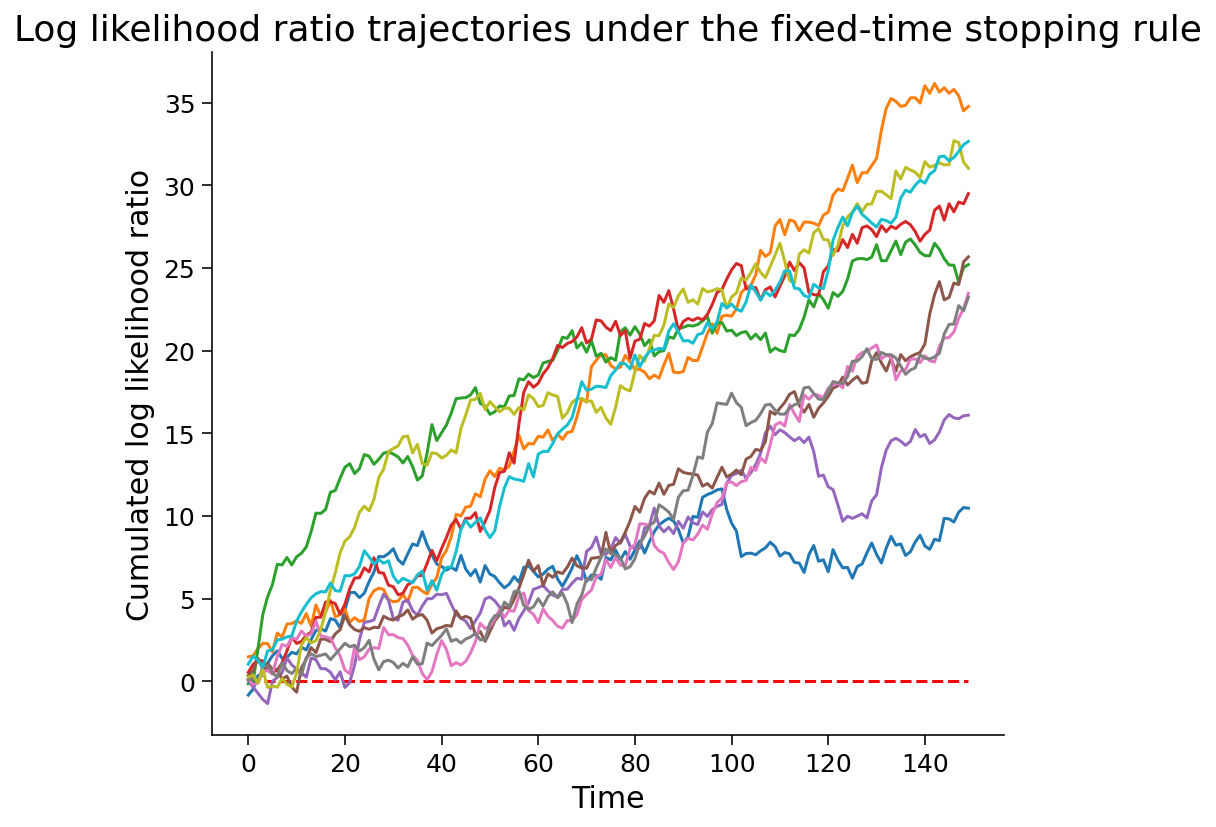

In [11]:
def simulate_SPRT_fixedtime(sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  #################################################
  ## TODO for students ##
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: complete simulate_SPRT_fixedtime")
  #################################################

  # Set means of observation distributions
  mu_pos = 1.0
  mu_neg = -1.0

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # Calculate cumulated evidence (S) given a vector of individual evidences (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # Make decision
  if evidence_history[-1] > 0:
    # Decision given positive S_t (last value of evidence history)
    decision = 1
  elif evidence_history[-1] < 0:
    # Decision given negative S_t (last value of evidence history)
    decision = -1
  else:
    # Random decision if S_t is 0
    decision = np.random.randint(2)

  return evidence_history, decision, Mvec


# Set random seed
np.random.seed(100)

# Set model parameters
sigma = 3.5  # standard deviation for p+ and p-
num_sample = 10  # number of simulations to run
stop_time = 150 # number of steps before stopping

simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_85d9b919.py)

*Example output:*

<img alt='Solution hint' align='left' width=573 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_85d9b919_1.png>



### Interactive Demo 2.1: Trajectories under the fixed-time stopping rule

In the following demo, you can change the noise level in the observation model (sigma) and the number of time steps before stopping (stop_time) using the sliders. You will then observe 10 simulations with those parameters. 
 


1.   Are you more likely to make the wrong decision (choose the incorrect state) with high or low noise?
2. What happens when sigma is very small? Why?
3.   Are you more likely to make the wrong decision (choose the incorrect state) with fewer or more time steps before stopping?





In [12]:
#@markdown Make sure you execute this cell to enable the widget!
def simulate_SPRT_fixedtime(sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  # Set means of observation distributions
  mu_pos = 1.0
  mu_neg = -1.0

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # Calculate cumulated evidence (S) given a vector of individual evidences (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # Make decision
  if evidence_history[-1] > 0:
    # Decision given positive S_t (last value of evidence history)
    decision = 1
  elif evidence_history[-1] < 0:
    # Decision given negative S_t (last value of evidence history)
    decision = -1
  else:
    # Random decision if S_t is 0
    decision = np.random.randint(2)

  return evidence_history, decision, Mvec

np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1)):
  simulate_and_plot_SPRT_fixedtime(sigma, stop_time, num_sample, verbose=False)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.05, step=0.05), IntSlider(va…

#### answer


1) Higher noise, or higher sigma, means that the evidence accumulation varies up
   and down more widely. You are more likely to make a wrong decision with high noise
   as the cumulated log likelihood ratio is more likely to be negative at the end
   despite the true distribution being s = 1.

2) When sigma is very small, the cumulated log likelihood ratios are basically a linear
   diagonal line. This is because each new measurement will be very similar (since they are
   being drawn from a Gaussian with a tiny standard deviation)

3) You are more likely to be wrong with a small number of time steps before decision. There is
   more change that the noise will affect the decision. We will explore this in the next section.

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_8ab841e6.py)



## Section 2.2: Accuracy vs stopping time


If you stop taking samples too early, (e.g., make a decision after only seeing 5 samples), or there's a huge amount of observation noise that buries the signal, you are likely to be driven by observation noise to a negative cumulated log likelihood ratio and thus make a wrong decision. You could get a sense of this by increasing noise level or decreasing stopping time in the last exercise.

Now let's look at how decision accuracy varies with the number of samples we see quantitatively.Accuracy is simply defined as the proportion of correct trials across our repeated simulations: $\frac{\# \textrm{ correct decisions}}{\# \textrm{ total simulation runs}}$.





### Coding Exercise 2: The Speed/Accuracy Tradeoff

We will fix our observation noise level. In this exercise you will implement a function to run several repeated simulations for a certain stopping time and calculate the average decision accuracy. We will then visualize the relation average decision accuracy and stopping time. 

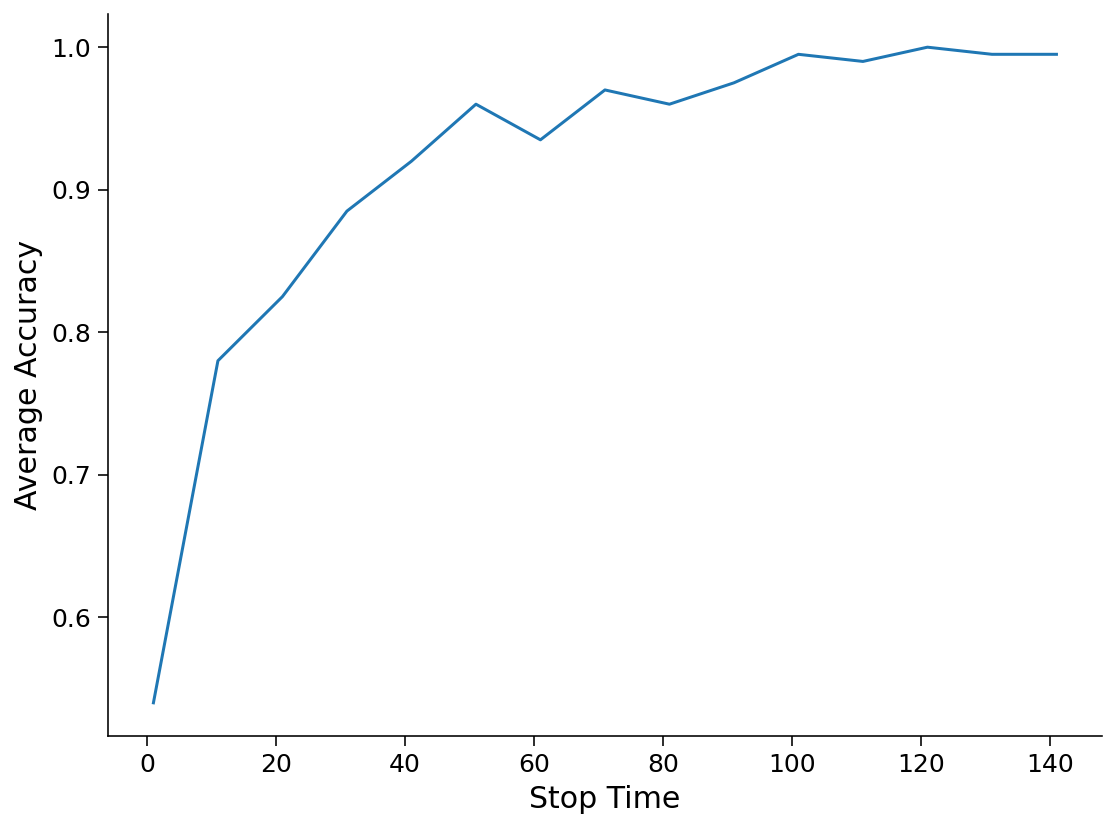

In [13]:
def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """

  #################################################
  ## TODO for students##
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: complete simulate_accuracy_vs_stoptime")
  #################################################

  # Determine true state (1 or -1)
  true_dist = 1

  # Set up tracker of accuracy and decisions
  accuracies = np.zeros(len(stop_time_list),)
  decisions_list = []

  # Loop over stop times
  for i_stop_time, stop_time in enumerate(stop_time_list):

    # Set up tracker of decisions for this stop time
    decisions = np.zeros((num_sample,))

    # Loop over samples
    for i in range(num_sample):

      # Simulate run for this stop time (hint: last exercise)
      _, decision, _= simulate_SPRT_fixedtime(sigma, stop_time, true_dist)

      # Log decision
      decisions[i] = decision

    # Calculate accuracy
    accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]

    # Log decisions
    decisions_list.append(decisions)

  return accuracies, decisions_list


# Set random seed
np.random.seed(100)

# Set parameters of model
sigma = 4.65  # standard deviation for observation noise
num_sample = 200  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Array of stopping times to use

# Calculate accuracies for each stop time
accuracies, _ = simulate_accuracy_vs_stoptime(sigma, stop_time_list,
                                                   num_sample)

# Visualize
plot_accuracy_vs_stoptime(stop_time_list, accuracies)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_d5a87445.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_d5a87445_0.png>



### Interactive Demo 2.2: Accuracy versus stop-time

In the following demo, we will show the same visualization as in the previous exercise, but you will be able to vary the noise level `sigma` of the observation distributions. First think and discuss, 



1.   What do you expect low levels of noise to do to the accuracy vs stop time plot?
2.   What do you expect high levels of noise to do to the accuracy vs stop time plot?

Play with the demo and see if you were correct or not.


In [14]:
#@markdown Make sure you execute this cell to enable the widget!
def simulate_accuracy_vs_stoptime(sigma, stop_time_list, num_sample):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """

  # Determine true state (1 or -1)
  true_dist = 1

  # Set up tracker of accuracy and decisions
  accuracies = np.zeros(len(stop_time_list),)
  decisions_list = []

  # Loop over stop times
  for i_stop_time, stop_time in enumerate(stop_time_list):

    # Set up tracker of decisions for this stop time (hint: last exercise)
    decisions = np.zeros((num_sample,))

    # Loop over samples
    for i in range(num_sample):

      # Simulate run for this stop time
      _, decision, _= simulate_SPRT_fixedtime(sigma, stop_time, true_dist)

      # Log decision
      decisions[i] = decision

    # Calculate accuracy
    accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]

    # Log decisions
    decisions_list.append(decisions)

  return accuracies, decisions_list

np.random.seed(100)
num_sample = 100
stop_time_list = np.arange(1, 150, 10)

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05)):
 # Calculate accuracies for each stop time
  accuracies, _ = simulate_accuracy_vs_stoptime(sigma, stop_time_list,                                             num_sample)

  # Visualize
  plot_accuracy_vs_stoptime(stop_time_list, accuracies)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.05, step=0.05), Output()), _…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_a956a168.py)



Please see Bonus Section 1 to learn about and work with a different stopping rule for DDMs: a fixed threshold on confidence.

---
# Summary

Good job! By simulating Drift Diffusion Models to perform decision making, you have learnt how to 

1. Calculate individual sample evidence as the log likelihood ratio of two candidate models, accumulate evidence from new data points, and make decision based on current evidence in `Exercise 1`
2. Run repeated simulations to get an estimate of decision accuraries in `Exercise 2`
3. Implement the thresholding stopping rule where we can control our error rate by taking adequate amounts of data, and calculate the evidence threshold from desired error rate in `Exercise 3`
4. Explore and gain intuition about the speed/accuracy tradeoff for perceptual decision making in `Exercise 4`

---
# Bonus 

## Bonus Section 1: DDM with fixed thresholds on confidence

In [15]:
# @title Video 6: Fixed threshold on confidence
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Ya4y1a7c1", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="E8lvgFeIGQM", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

The next exercises consider a variant of the DDM with fixed confidence thresholds instead of fixed decision time. This may be a better description of neural integration. Please complete this material after you have finished the main content of all tutorials, if you would like extra information about this topic.

### Exercise 3: Simulating the DDM with fixed thresholds

In this exercise, we will use thresholding as our stopping rule and observe the behavior of the DDM. 

With thresholding stopping rule, we define a desired error rate and will continue making measurements until that error rate is reached. Experimental evidence suggested that evidence accumulation and thresholding stopping strategy happens at neuronal level (see [this article](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.29.051605.113038) for further reading).

* Complete the function `threshold_from_errorrate` to calculate the evidence threshold from desired error rate $\alpha$ as described in the formulas below. The evidence thresholds $th_1$ and $th_0$ for $p_+$ and $p_-$ are opposite of each other as shown below, so you can just return the absolute value.
$$
\begin{align}
 th_{L} &= \log \frac{\alpha}{1-\alpha} &= -th_{R} \\
 th_{R} &= \log \frac{1-\alpha}{\alpha} &= -th{_1}\\
 \end{align}
 $$

* Complete the function `simulate_SPRT_threshold` to simulate an SPRT with thresholding stopping rule given noise level and desired threshold 

* Run repeated simulations for a given noise level and a desired error rate visualize the DDM traces using our provided code 


#Trial	Time	Cumulated Evidence	Decision
0	85	15.642744	1
1	105	14.976339	1
2	30	15.054191	1
3	40	15.084403	1
4	44	16.322120	1
5	35	16.149337	1
6	86	15.398309	1
7	67	15.370047	1
8	23	15.690608	1
9	83	15.078331	1


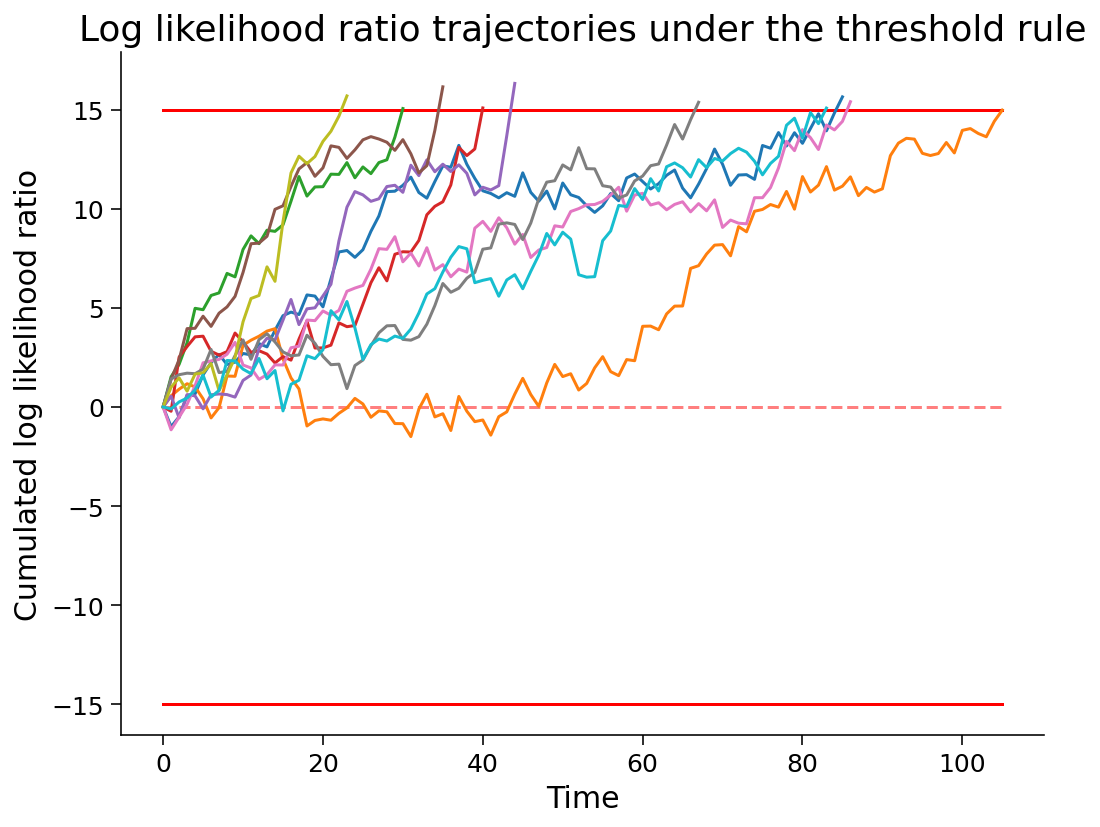

In [17]:
def simulate_SPRT_threshold(sigma, threshold , true_dist=1):
  """Simulate a Sequential Probability Ratio Test with thresholding stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    sigma (float): Standard deviation
    threshold (float): Desired log likelihood ratio threshold to achieve
                        before making decision

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  muL = -1.0
  muR = 1.0

  pL = stats.norm(muL, sigma)
  pR = stats.norm(muR, sigma)

  has_enough_data = False

  data_history = []
  evidence_history = []
  current_evidence = 0.0

  # Keep sampling data until threshold is crossed
  while not has_enough_data:
    if true_dist == 1:
      Mvec = pR.rvs()
    else:
      Mvec = pL.rvs()

    ########################################################################
    # Insert your code here to:
    #      * Calculate the log-likelihood ratio for the new sample
    #      * Update the accumulated evidence
    # raise NotImplementedError("`simulate_SPRT_threshold` is incomplete")
    ########################################################################
    # individual log likelihood ratios
    ll_ratio = log_likelihood_ratio(Mvec, pL, pR)
    # cumulated evidence for this chunk
    evidence_history.append(ll_ratio + current_evidence)
    # update the collection of all data
    data_history.append(Mvec)
    current_evidence = evidence_history[-1]

    # check if we've got enough data
    if abs(current_evidence) > threshold:
      has_enough_data = True

  data_history = np.array(data_history)
  evidence_history = np.array(evidence_history)

  # Make decision
  if evidence_history[-1] > 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0
  else:
    decision = np.random.randint(2)

  return evidence_history, decision, data_history


np.random.seed(100)
sigma = 2.8
num_sample = 10
log10_alpha = -6.5 # log10(alpha)
alpha = np.power(10.0, log10_alpha)

################################################################################
# Un-comment the following code after completing this exercise
################################################################################
simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_f93723a3.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_f93723a3_2.png>



### Interactive Demo: DDM with fixed threshold

**Suggestion**

* Play with difference values of `alpha` and `sigma` and observe how that affects the dynamics of Drift-Diffusion Model.

In [18]:
#@title

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), log10_alpha=(-8, -1, .1)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_SPRT_fixedthreshold(sigma, num_sample, alpha, verbose=False)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.05, step=0.05), FloatSlider(…

### Exercise 4: Speed/Accuracy Tradeoff Revisited

The faster you make a decision, the lower your accuracy often is. This phenomenon is known as the **speed/accuracy tradeoff**. Humans can make this tradeoff in a wide range of situations, and many animal species, including ants, bees, rodents, and monkeys also show similar effects. 

To illustrate the speed/accuracy tradeoff under thresholding stopping rule, let's run some simulations under different thresholds and look at how average decision "speed" (1/length) changes with average decision accuracy. We use speed rather than accuracy because in real experiments, subjects can be incentivized to respond faster or slower; it's much harder to precisely control their decision time or error threshold. 

* Complete the function `simulate_accuracy_vs_threshold` to simulate and compute average accuracies vs. average decision lengths for a list of error thresholds. You will need to supply code to calculate average decision 'speed' from the lengths of trials. You should also calculate the overall accuracy across these trials. 

* We've set up a list of error thresholds. Run repeated simulations and collect average accuracy with average length for each error rate in this list, and use our provided code to visualize the speed/accuracy tradeoff. You should see a positive correlation between length and accuracy.


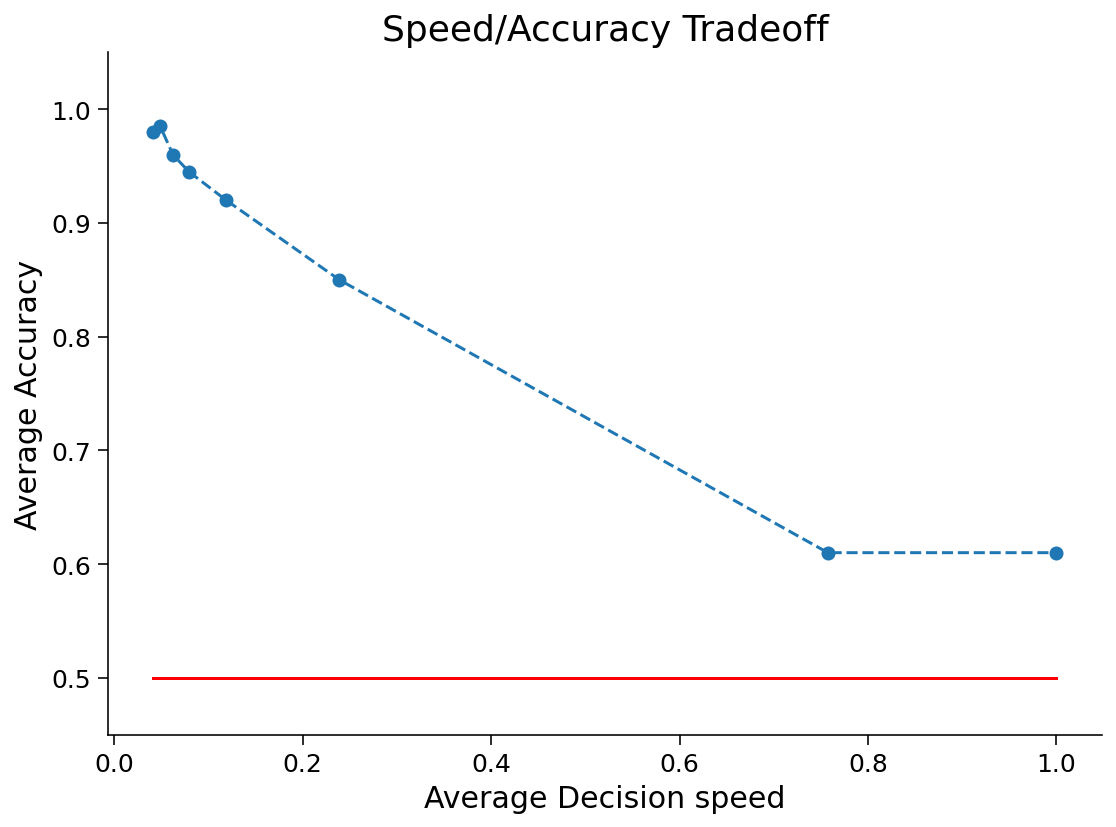

In [20]:
def simulate_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Calculate the average decision accuracy vs. average decision length by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.

  Args:
      sigma (float): standard deviation for observation model
      threshold_list (list-like object): a list of evidence thresholds to run
                                          over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_speed_list: a list of average decision speeds
  """
  decision_speed_list = []
  accuracy_list = []
  for threshold in threshold_list:
    decision_time_list = []
    decision_list = []
    for i in range(num_sample):
      # run simulation and get decision of current simulation
      _, decision, Mvec = simulate_SPRT_threshold(sigma, threshold)
      decision_time = len(Mvec)
      decision_list.append(decision)
      decision_time_list.append(decision_time)

    ########################################################################
    # Insert your code here to:
    #      * Calculate mean decision speed given a list of decision times
    #      * Hint: Think about speed as being inversely proportional
    #        to decision_length. If it takes 10 seconds to make one decision,
    #        our "decision speed" is 0.1 decisions per second.
    #      * Calculate the decision accuracy
    # raise NotImplementedError("`simulate_accuracy_vs_threshold` is incomplete")
    ########################################################################
    # Calculate and store average decision speed and accuracy
    decision_speed = np.mean(1. / np.array(decision_time_list))
    decision_accuracy = sum(decision_list) / len(decision_list)
    decision_speed_list.append(decision_speed)
    accuracy_list.append(decision_accuracy)

  return accuracy_list, decision_speed_list


################################################################################
# Un-comment the following code block after completing this exercise
################################################################################
np.random.seed(100)
sigma = 3.75
num_sample = 200
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)
simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_656ae75a.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_656ae75a_0.png>



### Interactive Demo: Speed/Accuracy with a threshold rule

**Suggestions**

* Play with difference values of  noise level `sigma` and observe how that affects the speed/accuracy tradeoff.

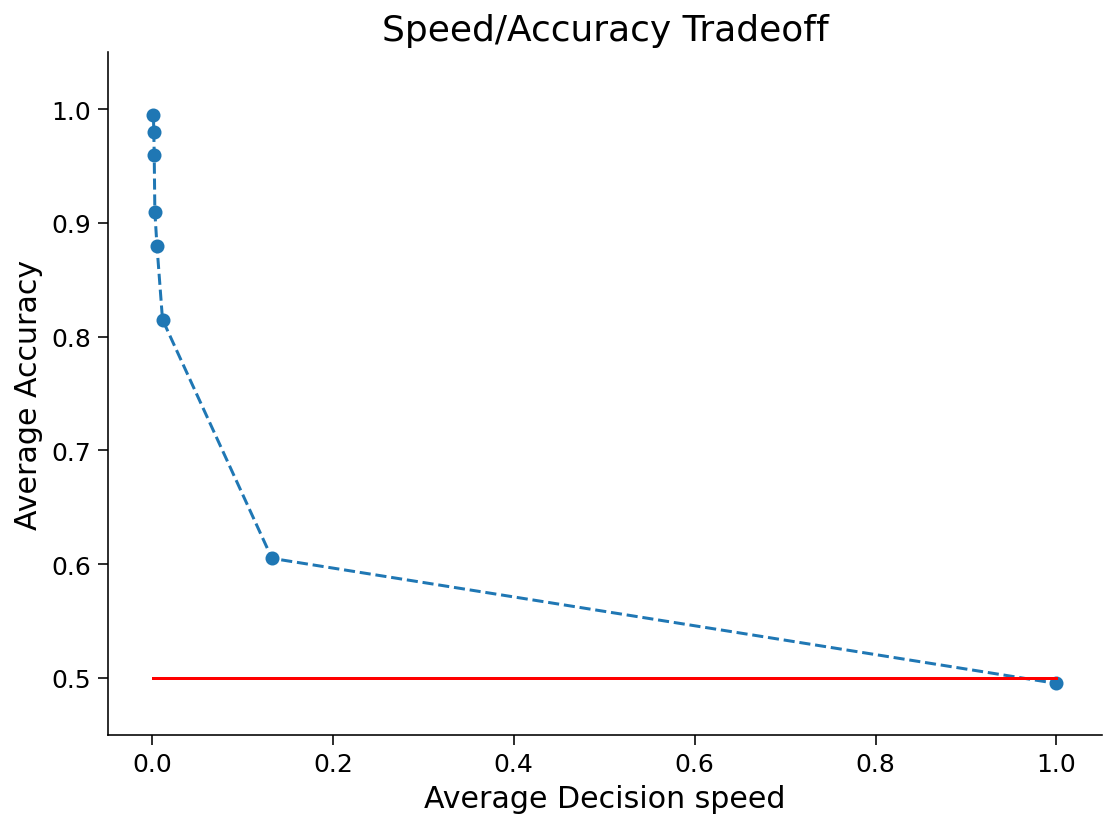

In [25]:
np.random.seed(100)
sigma = 20
num_sample = 200
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)
simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

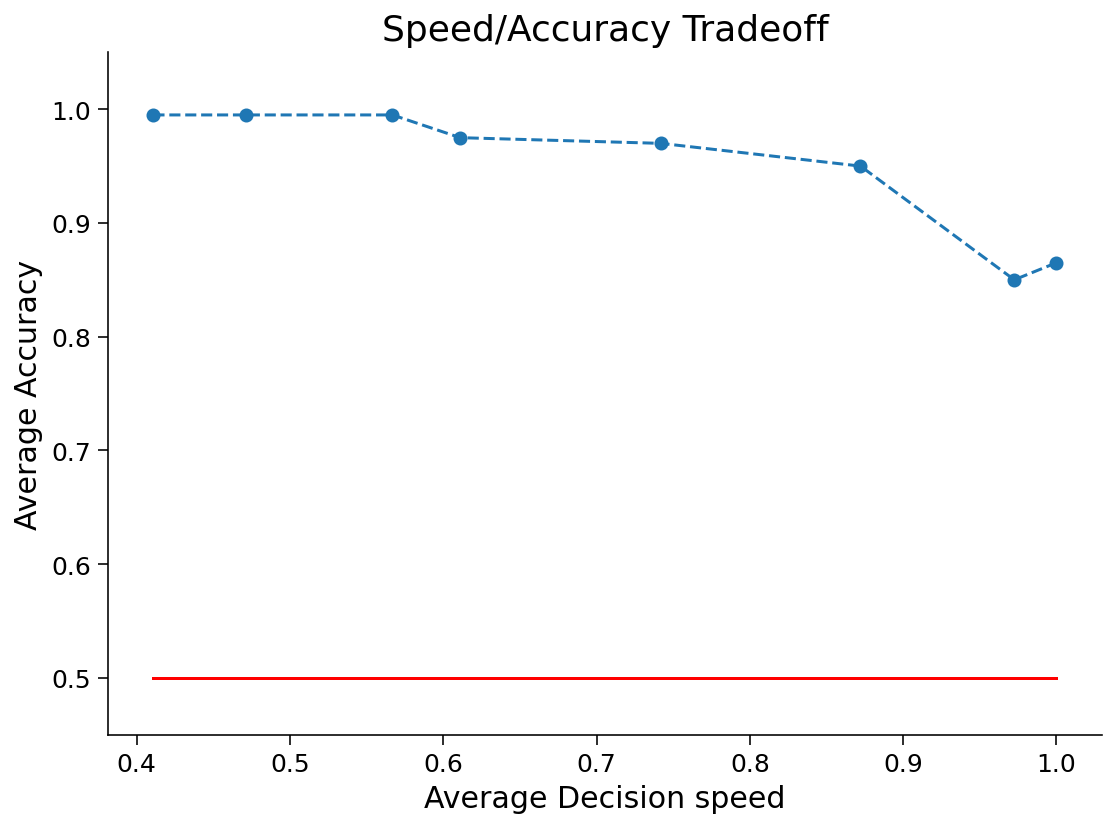

In [26]:
np.random.seed(100)
sigma = 1
num_sample = 200
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)
simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

In [22]:
#@title

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(100)
num_sample = 100
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.05, step=0.05), Output()), _…